# Fine-tuning a final set of `training` chips - finding chips to exclude, include


Check the ref veg height stats of the labels (chip .npy files) used for CHM model dev

In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
import contextily as ctx

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_660652/2792315985.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
df_stats = pd.read_csv('/explore/nobackup/people/jacaraba/development/above-shrubs.pytorch/tests/metadata_training_stats_with_mad.csv', skiprows=1) #actually nmad, not mad

In [3]:
df_stats.rename(columns={'mad': 'nmad'}, inplace=True)

In [4]:
#df['file'] = df['filename'].str.split('/', expand=True)[-1]
df_stats['chipName'] = df_stats['filename'].apply(os.path.basename).str.split('.', expand=True)[0]

In [5]:
df_stats.shape

(473790, 7)

array([[<Axes: title={'center': 'max'}>]], dtype=object)

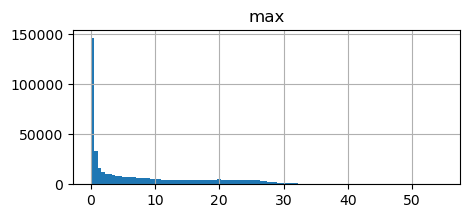

In [16]:
df_stats.hist('max', bins=100, figsize=(5,2))

array([[<Axes: title={'center': 'min'}>]], dtype=object)

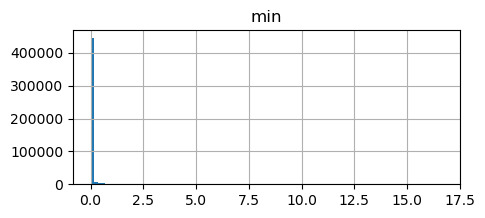

In [7]:
df_stats.hist('min', bins=100, figsize=(5,2))

array([[<Axes: title={'center': 'median'}>]], dtype=object)

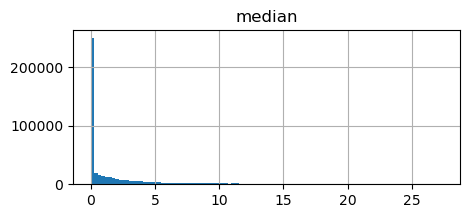

In [8]:
df_stats.hist('median', bins=100, figsize=(5,2))

array([[<Axes: title={'center': 'nmad'}>]], dtype=object)

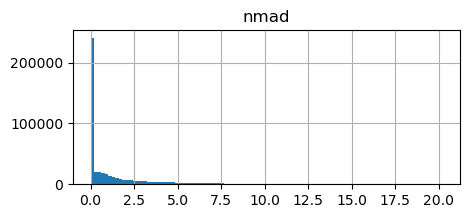

In [31]:
df_stats.hist('nmad', bins=100, figsize=(5,2))

In [87]:
df_stats.shape

(473790, 7)

## Read in the prepared `gpkg` footprints of the chips

In [6]:
gdf_chips_ifsar = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_ifsar_chm_nodtm_v20231014.gpkg')
gdf_chips_lidar = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_lidar_nodtm_v20231014.gpkg')

In [7]:
#gdf_chips_lidar.chipName.to_list()

In [8]:
#gdf_chips_lidar[gdf_chips_lidar.filename.isnull()].shape

In [9]:
gdf_chips_ifsar['source_type'] = 'sar'
gdf_chips_lidar['source_type'] = 'lidar'

In [10]:
gdf_chips = pd.concat([gdf_chips_ifsar,gdf_chips_lidar])

In [11]:
gdf_chips_lidar.shape

(230294, 17)

In [12]:
gdf_chips.shape

(499296, 18)

In [13]:
gdf_chips.shape

(499296, 18)

In [14]:
gdf_chips.chipName.to_list()[0:5]

['chip_WV02_20190705_M1BS_10300100955F1E00_CHM_AK_IFSAR_CHM_00001_v20231006',
 'chip_WV02_20190705_M1BS_10300100957DA000_CHM_AK_IFSAR_CHM_00001_v20231006',
 'chip_WV02_20190705_M1BS_10300100955F1E00_CHM_AK_IFSAR_CHM_00002_v20231006',
 'chip_WV02_20190705_M1BS_10300100955F1E00_CHM_AK_IFSAR_CHM_00003_v20231006',
 'chip_WV02_20170723_M1BS_103001006BD7B700_CHM_AK_IFSAR_CHM_00004_v20231006']

In [15]:
df_stats.chipName.to_list()[0:5]

['chip_WV02_20100709_M1BS_1030010006544A00_CHM_AK_IFSAR_CHM_00002_v20231006',
 'chip_WV02_20100709_M1BS_1030010006544A00_CHM_AK_IFSAR_CHM_00005_v20231006',
 'chip_WV02_20100709_M1BS_1030010006544A00_CHM_AK_IFSAR_CHM_00008_v20231006',
 'chip_WV02_20100709_M1BS_1030010006544A00_CHM_AK_IFSAR_CHM_00016_v20231006',
 'chip_WV02_20100709_M1BS_1030010006544A00_CHM_AK_IFSAR_CHM_00021_v20231006']

## Join the `stats` to the `chips footprints`

In [16]:
gdf_chips_merged = pd.merge(gdf_chips, df_stats, on='chipName', how='left')

In [17]:
gdf_chips_merged.shape

(499296, 24)

### Find filenames with null values and remove

In [18]:
gdf_chips_merged[~gdf_chips_merged.filename.isnull()].shape

(473786, 24)

In [19]:
gdf_chips_merged = gdf_chips_merged[~gdf_chips_merged.filename.isnull()]

In [20]:
gdf_chips_merged.shape

(473786, 24)

### Find `training` chips that dont have stats - the above step makes this `0`

In [21]:
cnt_chips_no_stats = gdf_chips_merged[gdf_chips_merged['max'].isna()].shape[0]
cnt_chips_no_stats

0

In [22]:
cnt_cips_stats= gdf_chips_merged[~gdf_chips_merged['max'].isna()].shape[0]
cnt_cips_stats

473786

In [23]:
df_stats.shape[0] + cnt_chips_no_stats

473790

### Convert to centroids to view

In [50]:
gdf_chips_merged_centroids = gdf_chips_merged.copy()
gdf_chips_merged_centroids['geometry'] = gdf_chips_merged_centroids['geometry'].centroid
gdf_chips_merged_centroids.crs

<Derived Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meters)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [48]:
#ctx.providers

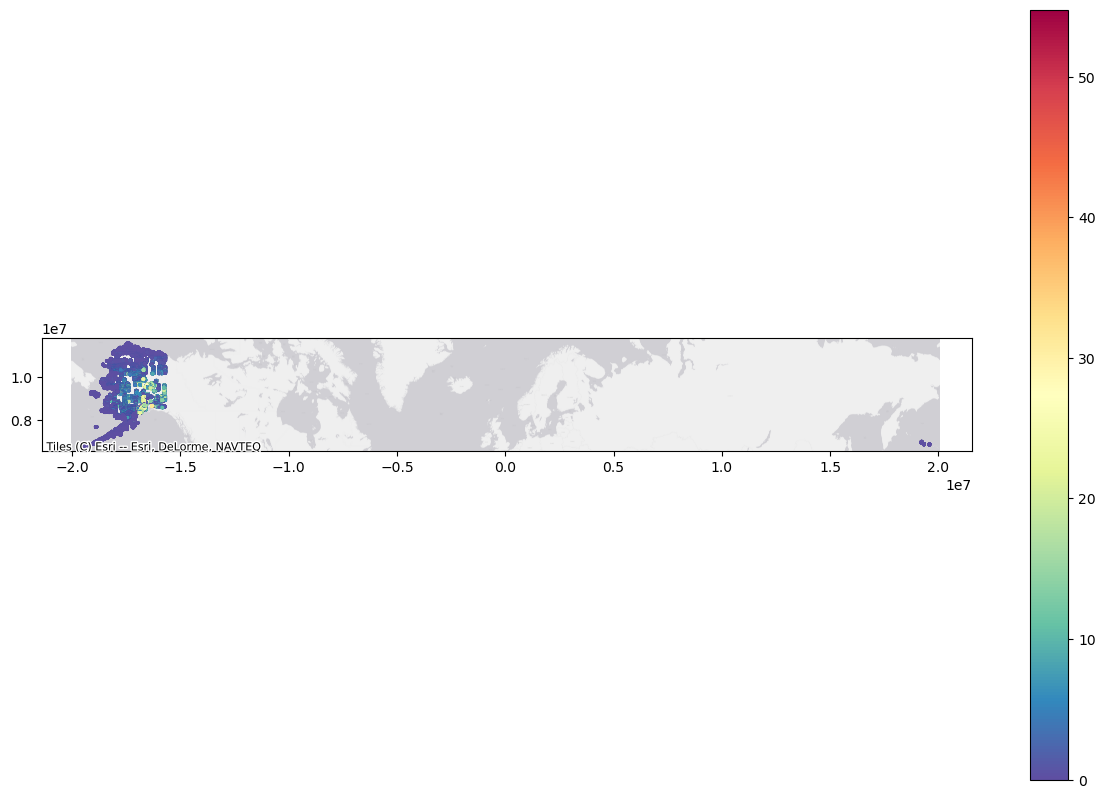

In [51]:
ax = gdf_chips_merged_centroids.to_crs(3857).plot(column='max', legend=True, markersize=2, cmap='Spectral_r', figsize=(15, 10))
ctx.add_basemap(ax
                , source=ctx.providers.Esri.WorldGrayCanvas
               )

## Choosing a chip exlusion filter using `max`, `median`, and `nmad`
### Setting a `max` threshold based on visual inspection of chips

In [96]:
MAX_VAL_primary = 46
MAX_VAL_secondary = 40
NUN_NMAD = 20

In [97]:
gdf_chips_exclude = gdf_chips_merged_centroids[ (gdf_chips_merged_centroids['max'] > MAX_VAL_primary) | 
                                                ((gdf_chips_merged_centroids['max'] > MAX_VAL_secondary) & (gdf_chips_merged_centroids['max'] > (gdf_chips_merged_centroids['median'] + NUN_NMAD * gdf_chips_merged_centroids['nmad']) ))
                                              ]
gdf_chips_exclude.shape

(12, 24)

In [98]:
gdf_chips_exclude.chipName.to_list()

['chip_WV02_20150824_M1BS_10300100486FE700_CHM_AK_IFSAR_CHM_01223_v20231006',
 'chip_WV02_20200805_M1BS_10300100ABC88800_CHM_fairbanks_ql1_2017_10424_v20231006',
 'chip_WV02_20200805_M1BS_10300100ABC88800_CHM_fairbanks_ql1_2017_03685_v20231006',
 'chip_WV02_20200805_M1BS_10300100ABC88800_CHM_fairbanks_ql1_2017_03538_v20231006',
 'chip_WV02_20190830_M1BS_10300100966ED400_CHM_fairbanks_ql1_2017_04843_v20231006',
 'chip_WV03_20190723_M1BS_10400100506ED100_CHM_fairbanks_ql2_2017_01227_v20231006',
 'chip_WV03_20160721_M1BS_1040010020A7AC00_CHM_infrastructure_2011_26906_01942_v20231006',
 'chip_WV03_20160721_M1BS_1040010020A7AC00_CHM_infrastructure_2011_26906_01916_v20231006',
 'chip_WV03_20170712_M1BS_104001002F0A4700_CHM_gliht_chm_2018_32606_00175_v20231006',
 'chip_WV02_20190830_M1BS_10300100966ED400_CHM_gliht_chm_2014_32605_01309_v20231006',
 'chip_WV03_20180701_M1BS_104001003F816800_CHM_gliht_chm_2018_32605_00119_v20231006',
 'chip_WV02_20180824_M1BS_1030010083446200_CHM_gliht_chm_2018_

### Subset of chips to include in training/testing

In [99]:
gdf_chips_merged_include = gdf_chips_merged[~gdf_chips_merged.chipName.isin(gdf_chips_exclude.chipName.to_list())]

In [100]:
gdf_chips_merged_include.shape

(473774, 24)

# Just `lidar` chips to include

In [101]:
gdf_chips_lidar_include_centroids = gdf_chips_merged_include[gdf_chips_merged_include.source_type == 'lidar'].copy()
gdf_chips_lidar_include_centroids['geometry'] = gdf_chips_lidar_include_centroids['geometry'].centroid
gdf_chips_lidar_include_centroids.shape

(218579, 24)

<Axes: >

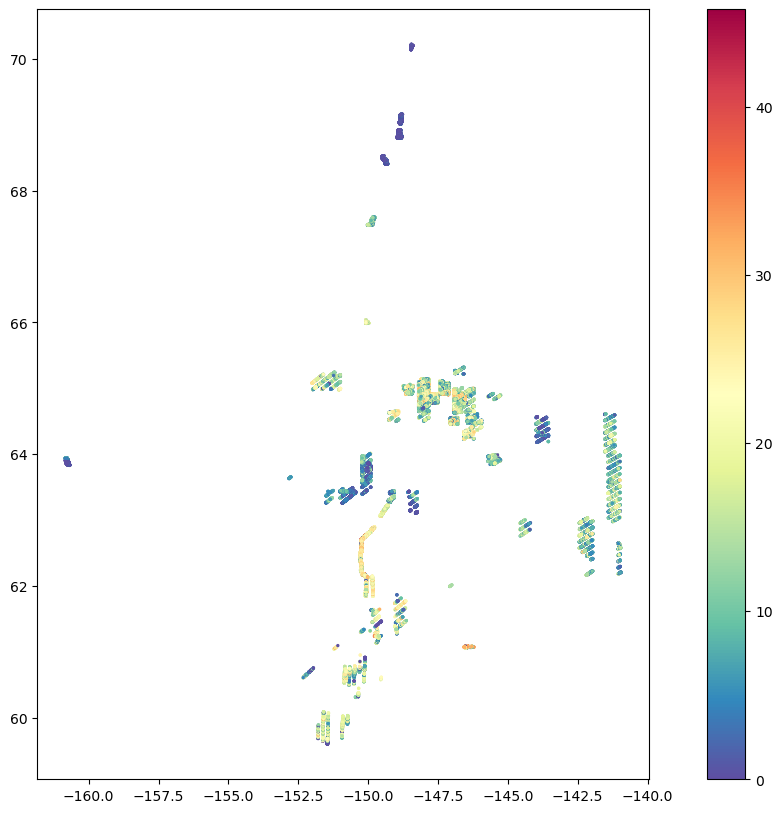

In [63]:
gdf_chips_lidar_include_centroids.to_crs(4326).plot(column='max', legend=True, markersize=2, cmap='Spectral_r', figsize=(15, 10))

## Interactive map example

In [1]:
#gdf_chips_lidar_include_centroids.head(100).explore(column='max', cmap='Spectral_r', tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="Esri")

# Random sample to separate training, testing, validation

In [103]:
# Split the GeoDataFrame
train, temp = train_test_split(gdf_chips_merged_include[gdf_chips_merged_include.source_type == 'lidar'], test_size=0.3, random_state=42)  # 70% training, 30% temp (for testing and validation)
test, validation = train_test_split(temp, test_size=1/3, random_state=42)  # Split the remaining 30% into 20% test and 10% validation

train['lidar_model_use'] = 'train'
test['lidar_model_use'] = 'test'
validation['lidar_model_use'] = 'validation'

# Now you have three GeoDataFrames
print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")
print(f"Validation set size: {len(validation)}")

# Optional: Save the splits if needed
train.to_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_train.gpkg', driver='GPKG')
test.to_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_test.gpkg', driver='GPKG')
validation.to_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_val.gpkg', driver='GPKG')

Training set size: 153005
Testing set size: 43716
Validation set size: 21858


In [104]:
gdf_chips_merged_include[gdf_chips_merged_include['filename'].isnull()].shape

(0, 24)

In [105]:
test[test['filename'].isnull()].shape

(0, 25)

### Inference set of LC maps can come from intersection with these sites

In [54]:
riparian_sites = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/NPS_riparian_points_AKAlb83m_20250215.shp')

In [61]:
riparian_sites.shape

(29833, 127)

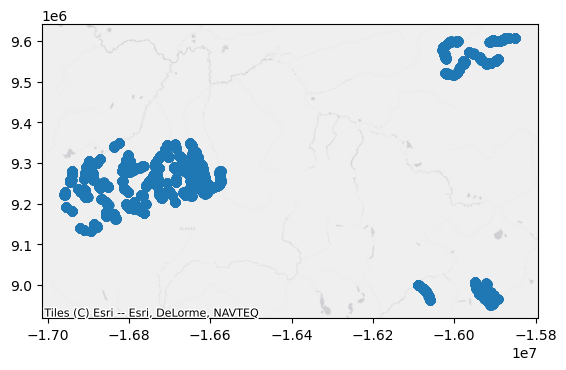

In [60]:
ax = riparian_sites.to_crs(3857).plot()
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)